### import

In [1]:
import pandas as pd
from collections import OrderedDict
import geopandas
import libpysal
from libpysal import cg, examples
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
import matplotlib_scalebar
from matplotlib_scalebar.scalebar import ScaleBar
import numpy
import ortools
from ortools.linear_solver import pywraplp
import seaborn
import shapely
from shapely.geometry import Point
import spaghetti
import sys

%matplotlib inline

# 한글폰트
import os
from matplotlib import font_manager, rc
path = 'C:/Windows/Fonts/malgun.ttf'
font_name = font_manager.FontProperties(fname=path, size=50).get_name()
plt.rc('font', family=font_name)
matplotlib.rcParams['axes.unicode_minus'] = False 

import numpy as np

c:\Users\chldl\Desktop\공부\공모전\통계데이터활용경진대회\Codespace\statics\lib\site-packages\spaghetti\network.py:36: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(f"{dep_msg}", FutureWarning)


### geopandas

In [ ]:
emd = geopandas.read_file('dataset\EMD_20220324\emd.shp', encoding = 'euc-kr')
emd = emd.to_crs(epsg=4326)
sig = geopandas.read_file('dataset\SIG_20220324\sig.shp', encoding = 'euc-kr')
sig = sig.to_crs(epsg=4326)

seoul_EMD = emd[emd['EMD_CD'].str.startswith('11')]
seoul_sig = sig[sig['SIG_CD'].str.startswith('11')]

seoul_EMD["SIG_CD"] = seoul_EMD["EMD_CD"].str[:5]
seoul = pd.merge(seoul_sig, seoul_EMD, how='left', left_on='SIG_CD', right_on="SIG_CD")

seoul2 = seoul[["SIG_CD", 'SIG_KOR_NM', 'EMD_CD', 'EMD_KOR_NM', 'geometry_y']]
seoul2

### 가중치

In [517]:
data_고령자 = pd.read_csv("DataSet\고령자현황_20221030155707.csv", header=3)
data_고령자 = data_고령자[["동별(3)", "소계"]]
data_고령자 = data_고령자.rename(columns={"동별(3)" : "행정동", "소계" : "고령자"})
data_고령자

,행정동,고령자
0,사직동,9379
1,삼청동,2659
2,부암동,9590
3,평창동,17952
4,무악동,8084
...,...,...
421,암사1동,34305
422,천호2동,33813
423,길동,45420
424,상일1동,39038


In [525]:
data_4세이하 = pd.read_csv("DataSet\주민등록인구(연령별_동별)_20221031192543.csv", header=4)
data_4세이하 = data_4세이하[["소계", "2721"]]
data_4세이하 = data_4세이하.rename(columns={"소계" : "행정동", "2721":"4세이하"})
data_4세이하 = data_4세이하.drop(data_4세이하[data_4세이하["행정동"] == "소계"].index)
data_4세이하

,행정동,4세이하
0,사직동,196
1,삼청동,37
2,부암동,144
3,평창동,445
4,무악동,219
...,...,...
444,송파제1동,658
445,문정제1동,795
446,잠실제1동,849
448,강일동,1722


In [528]:
data_기초생활 = pd.read_csv("DataSet\국민기초생활보장+수급자(2020년+이후)_20221031191012.csv", header=5, encoding="cp949")
data_기초생활 = data_기초생활[["소계", "5,559"]]
data_기초생활 = data_기초생활.rename(columns={"소계" : "행정동", "5,559":"기초생활"})
data_기초생활 = data_기초생활.drop(data_기초생활[data_기초생활["행정동"] == "소계"].index)
data_기초생활

,행정동,기초생활
0,사직동,125
1,삼청동,45
2,부암동,174
3,평창동,144
4,무악동,206
...,...,...
470,천호2동,"2,002"
471,길동,"1,637"
472,상일1동,396
473,상일2동,689


In [519]:
data_장애인 = pd.read_csv("DataSet\장애인+현황(등급별_동별)_20221030155742.csv", header=3)
data_장애인 = data_장애인[["동별(3)", "계.1"]]
data_장애인 = data_장애인.rename(columns={"동별(3)" : "행정동", "계.1":"장애"})
data_장애인

,행정동,장애
0,사직동,136
1,삼청동,39
2,부암동,121
3,평창동,199
4,무악동,125
...,...,...
424,천호2동,597
425,길동,708
426,상일1동,421
427,상일2동,238


In [504]:
data_약국소비 = pd.read_csv("DataSet\sales_dong.csv")
data_약국소비 = data_약국소비[["dong_code", "mdwk_selng_amt", "wkend_selng_amt"]]
round(data_약국소비[["mdwk_selng_amt", "wkend_selng_amt"]], 2)
data_약국소비.columns = ["행정동", "주중 매출", "주말 매출"]
data_약국소비 = data_약국소비.astype({"행정동":"object"})
data_약국소비.head(2)

,행정동,주중 매출,주말 매출
0,1101053,2.294900e+08,2.015301e+07
1,1101054,1.429346e+08,1.002422e+07


In [529]:
seoul2

,SIG_CD,SIG_KOR_NM,EMD_CD,EMD_KOR_NM,geometry_y
0,11110,종로구,11110101,청운동,"POLYGON ((126.97556 37.58968, 126.97549 37.589..."
1,11110,종로구,11110102,신교동,"POLYGON ((126.97031 37.58418, 126.97033 37.584..."
2,11110,종로구,11110103,궁정동,"POLYGON ((126.97400 37.58654, 126.97401 37.586..."
3,11110,종로구,11110104,효자동,"POLYGON ((126.97356 37.58323, 126.97355 37.582..."
4,11110,종로구,11110105,창성동,"POLYGON ((126.97353 37.58182, 126.97354 37.581..."
...,...,...,...,...,...
462,11740,강동구,11740106,둔촌동,"POLYGON ((127.15669 37.53756, 127.15654 37.537..."
463,11740,강동구,11740107,암사동,"POLYGON ((127.14353 37.55490, 127.14343 37.554..."
464,11740,강동구,11740108,성내동,"POLYGON ((127.13424 37.53556, 127.13423 37.535..."
465,11740,강동구,11740109,천호동,"POLYGON ((127.14153 37.55080, 127.14154 37.550..."


In [530]:
가중치 = pd.merge(seoul2, data_고령자, how="left", left_on="EMD_KOR_NM", right_on="행정동")
가중치

,SIG_CD,SIG_KOR_NM,EMD_CD,EMD_KOR_NM,geometry_y,행정동,고령자
0,11110,종로구,11110101,청운동,"POLYGON ((126.97556 37.58968, 126.97549 37.589...",NaN,NaN
1,11110,종로구,11110102,신교동,"POLYGON ((126.97031 37.58418, 126.97033 37.584...",NaN,NaN
2,11110,종로구,11110103,궁정동,"POLYGON ((126.97400 37.58654, 126.97401 37.586...",NaN,NaN
3,11110,종로구,11110104,효자동,"POLYGON ((126.97356 37.58323, 126.97355 37.582...",NaN,NaN
4,11110,종로구,11110105,창성동,"POLYGON ((126.97353 37.58182, 126.97354 37.581...",NaN,NaN
...,...,...,...,...,...,...,...
464,11740,강동구,11740106,둔촌동,"POLYGON ((127.15669 37.53756, 127.15654 37.537...",NaN,NaN
465,11740,강동구,11740107,암사동,"POLYGON ((127.14353 37.55490, 127.14343 37.554...",NaN,NaN
466,11740,강동구,11740108,성내동,"POLYGON ((127.13424 37.53556, 127.13423 37.535...",NaN,NaN
467,11740,강동구,11740109,천호동,"POLYGON ((127.14153 37.55080, 127.14154 37.550...",NaN,NaN


In [ ]:
가중치 = pd.merge(가중치, data_장애인, how="outer", on="행정동")

In [95]:
가중치 = pd.read_csv("가중치.csv", encoding="cp949", index_col=0)
가중치2 = 가중치.fillna(round(가중치.mean(), 2))
가중치2.to_csv("가중치.csv")

,자치구,행정동,고령자,의료인력,심한 장애,심하지 않은 장애
0,종로구,사직동,9379.0,354.0,136.0,141.0
1,종로구,삼청동,2659.0,105.0,39.0,69.0
2,종로구,부암동,9590.0,221.0,121.0,197.0
3,종로구,평창동,17952.0,95.0,199.0,314.0
4,종로구,무악동,8084.0,247.0,125.0,197.0
...,...,...,...,...,...,...
429,강동구,길동,45420.0,1486.0,708.0,1275.0
430,강동구,상일1동,39038.0,NaN,421.0,614.0
431,강동구,상일2동,11971.0,NaN,238.0,307.0
432,영등포구,여의도동,NaN,1753.0,NaN,NaN


In [276]:
가중치2 = pd.read_csv("가중치.csv", encoding="cp949", index_col=0)
가중치2

,자치구,행정동,고령자,의료인력,심한 장애,심하지 않은 장애
0,종로구,사직동,9379.00,354.00,136.00,141.00
1,종로구,삼청동,2659.00,105.00,39.00,69.00
2,종로구,부암동,9590.00,221.00,121.00,197.00
3,종로구,평창동,17952.00,95.00,199.00,314.00
4,종로구,무악동,8084.00,247.00,125.00,197.00
...,...,...,...,...,...,...
429,강동구,길동,45420.00,1486.00,708.00,1275.00
430,강동구,상일1동,39038.00,353.65,421.00,614.00
431,강동구,상일2동,11971.00,353.65,238.00,307.00
432,영등포구,여의도동,22695.53,1753.00,345.59,571.29


In [277]:
서울 = geopandas.read_file("DataSet/Z_SOP_BND_ADM_DONG_PG/Z_SOP_BND_ADM_DONG_PG.shp", encoding = 'euc-kr')
서울 = 서울.to_crs(epsg=4326)
서울 = 서울[서울["ADM_DR_CD"].str.startswith("11")]

In [278]:
서울 = 서울[서울["ADM_DR_CD"].str.startswith("11")]
가중치3 = pd.merge(서울, 가중치2, how="left", left_on="ADM_DR_NM", right_on="행정동")

In [279]:
가중치3

,BASE_DATE,ADM_DR_CD,ADM_DR_NM,OBJECTID,geometry,자치구,행정동,고령자,의료인력,심한 장애,심하지 않은 장애
0,20210630,1101053,사직동,1,"POLYGON ((126.97399 37.57823, 126.97400 37.578...",종로구,사직동,9379.0,354.0,136.0,141.0
1,20210630,1101054,삼청동,2,"POLYGON ((126.97714 37.59768, 126.97730 37.597...",종로구,삼청동,2659.0,105.0,39.0,69.0
2,20210630,1101055,부암동,3,"POLYGON ((126.96173 37.60714, 126.96182 37.607...",종로구,부암동,9590.0,221.0,121.0,197.0
3,20210630,1101056,평창동,4,"POLYGON ((126.97509 37.63118, 126.97488 37.630...",종로구,평창동,17952.0,95.0,199.0,314.0
4,20210630,1101057,무악동,5,"POLYGON ((126.95975 37.58001, 126.96006 37.579...",종로구,무악동,8084.0,247.0,125.0,197.0
...,...,...,...,...,...,...,...,...,...,...,...
434,20210630,1125070,둔촌1동,421,"POLYGON ((127.14480 37.51939, 127.14483 37.519...",강동구,둔촌1동,81.0,4.0,1.0,2.0
435,20210630,1125071,둔촌2동,422,"POLYGON ((127.15656 37.53746, 127.15654 37.537...",강동구,둔촌2동,24343.0,1558.0,337.0,598.0
436,20210630,1125072,암사1동,423,"POLYGON ((127.13568 37.55472, 127.13569 37.554...",강동구,암사1동,34305.0,137.0,630.0,1052.0
437,20210630,1125073,천호2동,424,"POLYGON ((127.11633 37.55005, 127.11642 37.550...",강동구,천호2동,33813.0,786.0,597.0,1051.0


In [280]:
가중치3 = 가중치3[["자치구", "ADM_DR_CD", "ADM_DR_NM", "고령자", "의료인력", "심한 장애", "심하지 않은 장애", "geometry"]]
가중치3

,자치구,ADM_DR_CD,ADM_DR_NM,고령자,의료인력,심한 장애,심하지 않은 장애,geometry
0,종로구,1101053,사직동,9379.0,354.0,136.0,141.0,"POLYGON ((126.97399 37.57823, 126.97400 37.578..."
1,종로구,1101054,삼청동,2659.0,105.0,39.0,69.0,"POLYGON ((126.97714 37.59768, 126.97730 37.597..."
2,종로구,1101055,부암동,9590.0,221.0,121.0,197.0,"POLYGON ((126.96173 37.60714, 126.96182 37.607..."
3,종로구,1101056,평창동,17952.0,95.0,199.0,314.0,"POLYGON ((126.97509 37.63118, 126.97488 37.630..."
4,종로구,1101057,무악동,8084.0,247.0,125.0,197.0,"POLYGON ((126.95975 37.58001, 126.96006 37.579..."
...,...,...,...,...,...,...,...,...
434,강동구,1125070,둔촌1동,81.0,4.0,1.0,2.0,"POLYGON ((127.14480 37.51939, 127.14483 37.519..."
435,강동구,1125071,둔촌2동,24343.0,1558.0,337.0,598.0,"POLYGON ((127.15656 37.53746, 127.15654 37.537..."
436,강동구,1125072,암사1동,34305.0,137.0,630.0,1052.0,"POLYGON ((127.13568 37.55472, 127.13569 37.554..."
437,강동구,1125073,천호2동,33813.0,786.0,597.0,1051.0,"POLYGON ((127.11633 37.55005, 127.11642 37.550..."


In [310]:
가중치3

,자치구,ADM_DR_CD,ADM_DR_NM,고령자,의료인력,심한 장애,심하지 않은 장애,geometry
0,종로구,1101053,사직동,9379.0,354.0,136.0,141.0,"POLYGON ((126.97399 37.57823, 126.97400 37.578..."
1,종로구,1101054,삼청동,2659.0,105.0,39.0,69.0,"POLYGON ((126.97714 37.59768, 126.97730 37.597..."
2,종로구,1101055,부암동,9590.0,221.0,121.0,197.0,"POLYGON ((126.96173 37.60714, 126.96182 37.607..."
3,종로구,1101056,평창동,17952.0,95.0,199.0,314.0,"POLYGON ((126.97509 37.63118, 126.97488 37.630..."
4,종로구,1101057,무악동,8084.0,247.0,125.0,197.0,"POLYGON ((126.95975 37.58001, 126.96006 37.579..."
...,...,...,...,...,...,...,...,...
434,강동구,1125070,둔촌1동,81.0,4.0,1.0,2.0,"POLYGON ((127.14480 37.51939, 127.14483 37.519..."
435,강동구,1125071,둔촌2동,24343.0,1558.0,337.0,598.0,"POLYGON ((127.15656 37.53746, 127.15654 37.537..."
436,강동구,1125072,암사1동,34305.0,137.0,630.0,1052.0,"POLYGON ((127.13568 37.55472, 127.13569 37.554..."
437,강동구,1125073,천호2동,33813.0,786.0,597.0,1051.0,"POLYGON ((127.11633 37.55005, 127.11642 37.550..."


In [ ]:
data_약국소비["약국소비"] = data_약국소비["주중 매출"] + data_약국소비["주말 매출"]
data_약국소비 = data_약국소비.drop(["주중 매출", "주말 매출"], axis=1)

In [338]:
가중치3["ADM_DR_CD"] = 가중치3["ADM_DR_CD"].astype(int)

In [353]:
가중치5 = pd.merge(가중치3, data_약국소비, how="left", left_on="ADM_DR_CD", right_on="행정동")
가중치5.columns

Index(['자치구', 'ADM_DR_CD', 'ADM_DR_NM', '고령자', '의료인력', '심한 장애', '심하지 않은 장애',
       'geometry', '행정동', '약국소비'],
      dtype='object')

In [ ]:
가중치5["장애"] = 가중치5["심한 장애"]

In [426]:
가중치5 = 가중치5[['자치구', 'ADM_DR_CD', 'ADM_DR_NM', '고령자', '의료인력', "장애", '약국소비',
       'geometry']]

In [427]:
가중치5 = 가중치5.fillna(round(가중치5.mean(), 2))
가중치5.isnull().sum()

C:\Users\chldl\AppData\Local\Temp\ipykernel_31636\4001049275.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  가중치5 = 가중치5.fillna(round(가중치5.mean(), 2))


자치구          0
ADM_DR_CD    0
ADM_DR_NM    0
고령자          0
의료인력         0
장애           0
약국소비         0
geometry     0
dtype: int64

In [428]:
가중치5

,자치구,ADM_DR_CD,ADM_DR_NM,고령자,의료인력,장애,약국소비,geometry
0,종로구,1101053,사직동,9379.0,354.0,137.0,2.496430e+08,"POLYGON ((126.97399 37.57823, 126.97400 37.578..."
1,종로구,1101054,삼청동,2659.0,105.0,45.0,1.529588e+08,"POLYGON ((126.97714 37.59768, 126.97730 37.597..."
2,종로구,1101055,부암동,9590.0,221.0,136.2,1.020520e+07,"POLYGON ((126.96173 37.60714, 126.96182 37.607..."
3,종로구,1101056,평창동,17952.0,95.0,222.0,2.387262e+08,"POLYGON ((126.97509 37.63118, 126.97488 37.630..."
4,종로구,1101057,무악동,8084.0,247.0,139.4,1.158703e+09,"POLYGON ((126.95975 37.58001, 126.96006 37.579..."
...,...,...,...,...,...,...,...,...
434,강동구,1125070,둔촌1동,81.0,4.0,1.2,3.908360e+06,"POLYGON ((127.14480 37.51939, 127.14483 37.519..."
435,강동구,1125071,둔촌2동,24343.0,1558.0,389.2,4.903286e+08,"POLYGON ((127.15656 37.53746, 127.15654 37.537..."
436,강동구,1125072,암사1동,34305.0,137.0,714.4,1.290348e+08,"POLYGON ((127.13568 37.55472, 127.13569 37.554..."
437,강동구,1125073,천호2동,33813.0,786.0,687.8,3.232069e+08,"POLYGON ((127.11633 37.55005, 127.11642 37.550..."


### 시각화

In [2]:
서울 = geopandas.read_file("DataSet/Z_SOP_BND_ADM_DONG_PG/Z_SOP_BND_ADM_DONG_PG.shp", encoding = 'euc-kr')
서울 = 서울.to_crs(epsg=4326)
서울 = 서울[서울["ADM_DR_CD"].str.startswith("11")]

In [6]:
서울.head(2)

,BASE_DATE,ADM_DR_CD,ADM_DR_NM,OBJECTID,geometry
0,20210630,1101053,사직동,1,"POLYGON ((126.97399 37.57823, 126.97400 37.578..."
1,20210630,1101054,삼청동,2,"POLYGON ((126.97714 37.59768, 126.97730 37.597..."


In [31]:
가중치 = pd.read_csv("PreprocessData\Medical Weighted Index.csv", encoding="cp949")
가중치.head(2)

,행정구역명,행정구역코드,고령자,수급자,중증장애,매출액,고령자_zscore,수급자_zscore,중증장애_zscore,매출액_zscore,고령자_tscore,수급자_tscore,중증장애_tscore,매출액_tscore,의료가중지수
0,가락1동,1124066,3460,112,215,1.326324e+08,-0.202330,-1.140143,-0.577222,-0.781478,47.976696,38.598567,44.227776,42.185216,42.971168
1,가락2동,1124067,4280,576,358,3.849759e+08,0.335325,-0.485926,0.047746,0.584405,53.353252,45.140736,50.477462,55.844047,52.801985


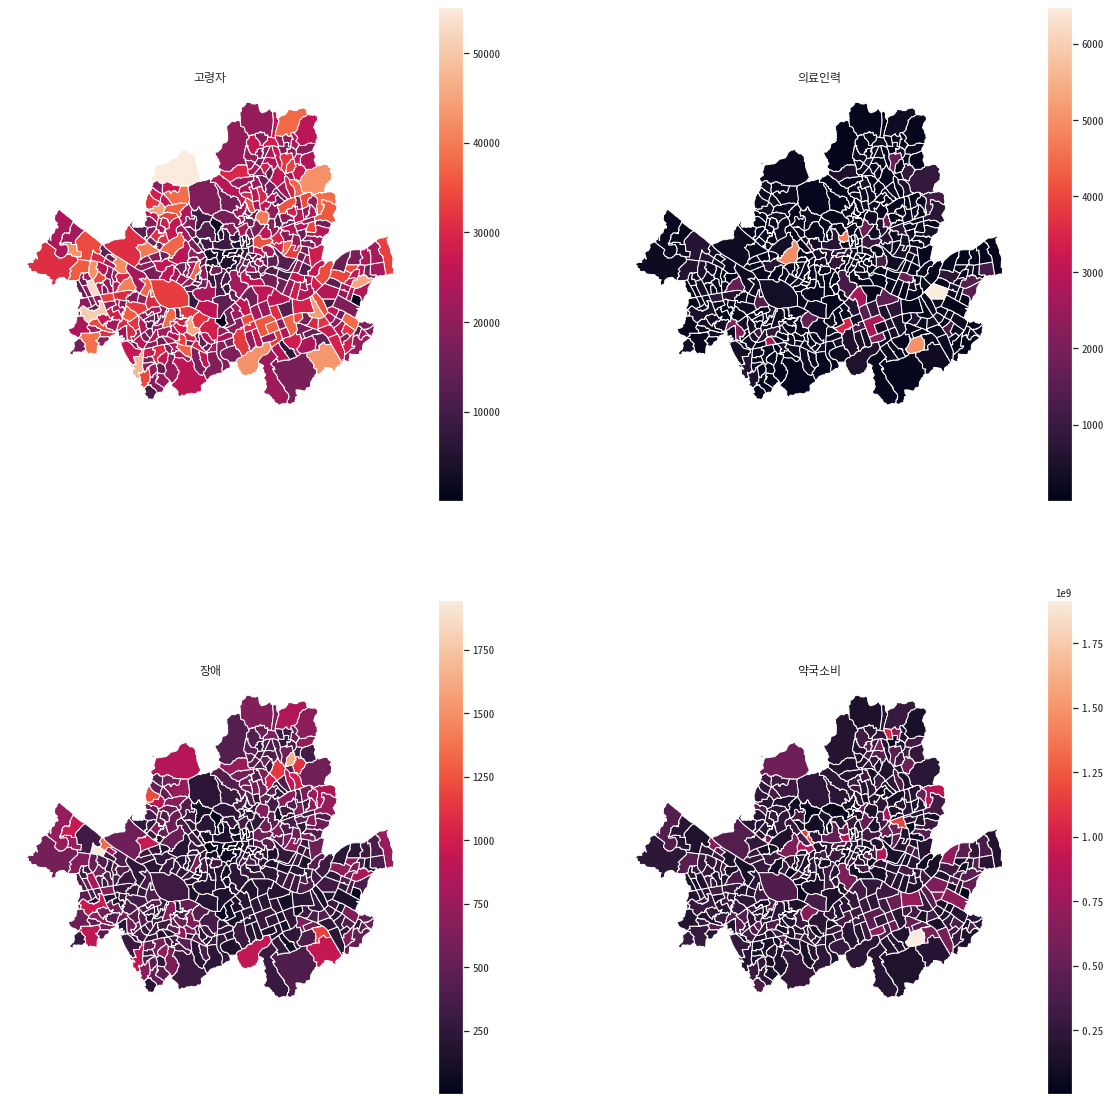

In [429]:
import seaborn as sns
col_n = 2
row_n = 2
title = ["고령자", "의료인력", "장애", "약국소비"]
fig, axes = plt.subplots(ncols=col_n, nrows=row_n, figsize=(20,row_n*10))

for i, col in enumerate(가중치5.columns[3:-1]):
    ax = 가중치5.plot(가중치5[col], ax=axes[int(i/col_n),int(i%col_n)], legend=True)
    ax.set_axis_off()
    ax.set_title(title[i])

In [430]:
가중치6 = 가중치5[["고령자", "의료인력", "장애", "약국소비"]]

In [458]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,5)) ## 각 칼럼 데이터 값을 0~3 범위로 변환
scaler.fit(가중치6) ## 각 칼럼 데이터마다 변환할 함수 생성
transformed_X = scaler.transform(가중치6) ## fit에서 만들어진 함수를 실제로 데이터에 적용
transformed_X = pd.DataFrame(transformed_X)
transformed_X.columns = ["고령자", "의료인력", "장애", "약국 소비"]

In [30]:
가중치

,행정구역명,행정구역코드,고령자,수급자,중증장애,매출액,고령자_zscore,수급자_zscore,중증장애_zscore,매출액_zscore,고령자_tscore,수급자_tscore,중증장애_tscore,매출액_tscore,의료가중지수
0,가락1동,1124066,3460,112,215,1.326324e+08,-0.202330,-1.140143,-0.577222,-0.577222,47.976696,38.598567,44.227776,44.227776,43.992448
1,가락2동,1124067,4280,576,358,3.849759e+08,0.335325,-0.485926,0.047746,0.047746,53.353252,45.140736,50.477462,50.477462,50.118693
2,가락본동,1124065,3811,739,264,2.643873e+08,0.027812,-0.256105,-0.363072,-0.363072,50.278124,47.438955,46.369277,46.369277,47.338240
3,가리봉동,1117070,2077,643,204,9.200030e+07,-1.109133,-0.391460,-0.625297,-0.625297,38.908675,46.085402,43.747030,43.747030,43.188574
4,가산동,1118051,2682,801,261,2.744201e+08,-0.712448,-0.168688,-0.376184,-0.376184,42.875524,48.313124,46.238164,46.238164,45.928754
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421,효창동,1103058,1489,132,97,5.191598e+08,-1.494671,-1.111944,-1.092931,-1.092931,35.053291,38.880557,39.070692,39.070692,38.233938
422,후암동,1103051,3026,907,306,1.161872e+08,-0.486894,-0.019233,-0.179515,-0.179515,45.131055,49.807671,48.204849,48.204849,47.870584
423,휘경1동,1106072,2106,386,180,1.491984e+08,-1.090118,-0.753817,-0.730187,-0.730187,39.098821,42.461830,42.698132,42.698132,41.936917
424,휘경2동,1106073,3992,703,298,1.163662e+09,0.146490,-0.306863,-0.214478,-0.214478,51.464901,46.931372,47.855216,47.855216,48.415480


In [32]:
가중치2 = 가중치.iloc[:, -5:-1]
가중치3 = 가중치.iloc[:, -5:]

In [33]:
가중치2

,고령자_tscore,수급자_tscore,중증장애_tscore,매출액_tscore
0,47.976696,38.598567,44.227776,42.185216
1,53.353252,45.140736,50.477462,55.844047
2,50.278124,47.438955,46.369277,49.316835
3,38.908675,46.085402,43.747030,39.985885
4,42.875524,48.313124,46.238164,49.859890
...,...,...,...,...
421,35.053291,38.880557,39.070692,63.107144
422,45.131055,49.807671,48.204849,41.295074
423,39.098821,42.461830,42.698132,43.081899
424,51.464901,46.931372,47.855216,97.992731


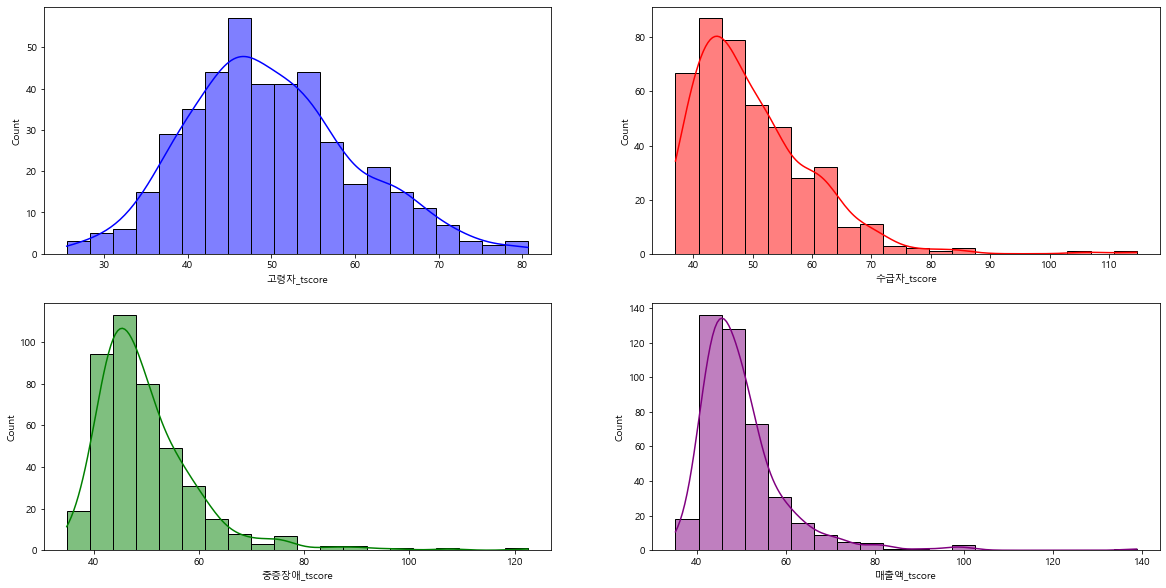

In [48]:
import seaborn as sns
col_n = 2
row_n = 2
color_map = ["blue" , "red", "green", "purple"]
fig, ax = plt.subplots(ncols=col_n, nrows=row_n, figsize=(20,row_n*5))
for i,col in enumerate(가중치2.columns):
    sns.histplot(가중치2[col], bins=20, ax=ax[int(i/col_n),int(i%col_n)], kde=True, color=color_map[i])

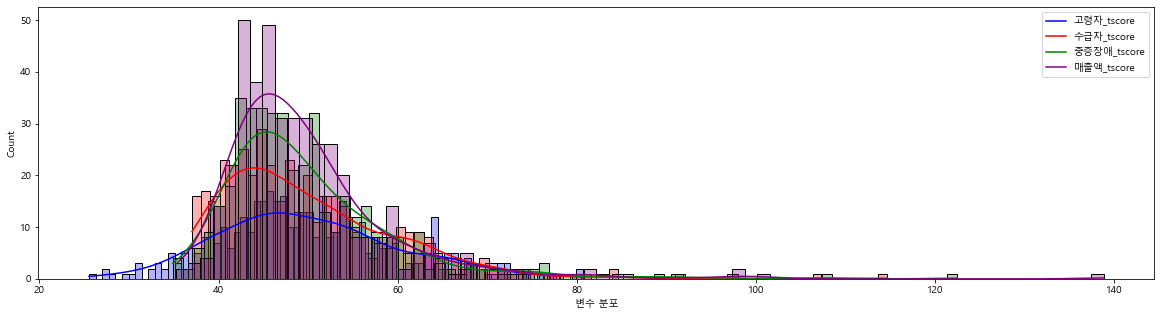

In [50]:
col_n = 1
row_n = 1

color_map = ["blue" , "red", "green", "purple"]

fig, ax = plt.subplots(ncols=col_n, nrows=row_n, figsize=(20,row_n*5))
for i,col in enumerate(가중치2.columns):
    sns.histplot(가중치2[col], bins=75, kde=True, color=color_map[i], alpha=0.3)
    plt.xlabel("변수 분포")
    plt.legend(가중치2.columns)

In [460]:
transformed_X

,고령자,의료인력,장애,약국 소비
0,0.843677,0.272083,0.349064,0.641874
1,0.233921,0.080160,0.112585,0.389329
2,0.862823,0.169570,0.347008,0.016448
3,1.621570,0.072453,0.567551,0.613358
4,0.726172,0.189610,0.355233,3.016393
...,...,...,...,...
434,0.000000,0.002312,0.000000,0.000000
435,2.201474,1.200092,0.997327,1.270559
436,3.105401,0.104825,1.833231,0.326838
437,3.060758,0.605056,1.764857,0.834027


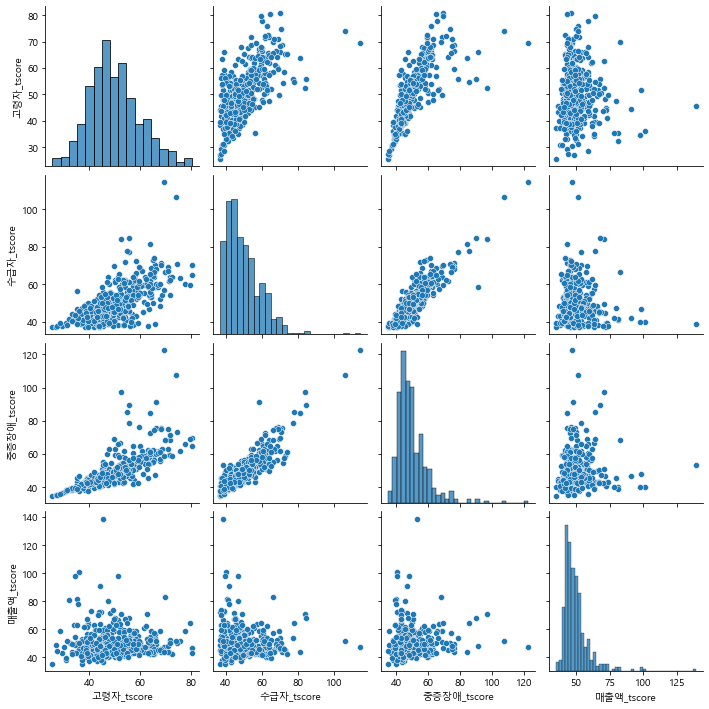

In [51]:
sns.pairplot(가중치2)
plt.show()

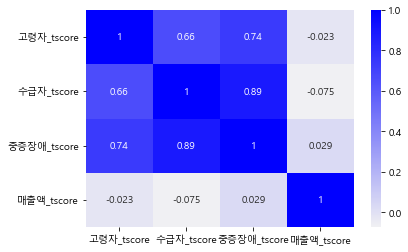

             고령자_tscore  수급자_tscore  중증장애_tscore  매출액_tscore
고령자_tscore     1.000000    0.657997     0.740463   -0.023024
수급자_tscore     0.657997    1.000000     0.886695   -0.074771
중증장애_tscore    0.740463    0.886695     1.000000    0.028528
매출액_tscore    -0.023024   -0.074771     0.028528    1.000000


In [52]:
cmap = sns.light_palette("blue", as_cmap=True)
sns.heatmap(가중치2.corr(), annot=True, cmap=cmap)
plt.show()
print(가중치2.corr())

In [463]:
transformed_X2 = transformed_X
transformed_X2["행정동"] = 가중치5["ADM_DR_CD"]
transformed_X2 = transformed_X2.set_index("행정동")
transformed_X2 = transformed_X2.reset_index()

In [470]:
transformed_X2["weights"] = transformed_X2["고령자"] + (5 - transformed_X2["의료인력"]) + transformed_X2["장애"] + transformed_X2["약국 소비"]
transformed_X2

,행정동,고령자,의료인력,장애,약국 소비,weights
0,1101053,0.843677,0.272083,0.349064,0.641874,6.562533
1,1101054,0.233921,0.080160,0.112585,0.389329,5.655675
2,1101055,0.862823,0.169570,0.347008,0.016448,6.056709
3,1101056,1.621570,0.072453,0.567551,0.613358,7.730027
4,1101057,0.726172,0.189610,0.355233,3.016393,8.908189
...,...,...,...,...,...,...
434,1125070,0.000000,0.002312,0.000000,0.000000,4.997688
435,1125071,2.201474,1.200092,0.997327,1.270559,8.269267
436,1125072,3.105401,0.104825,1.833231,0.326838,10.160644
437,1125073,3.060758,0.605056,1.764857,0.834027,10.054586


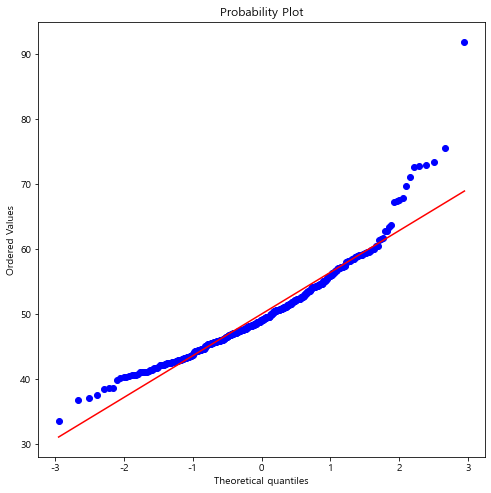

In [53]:
from scipy.stats import probplot
 
fig = plt.figure(figsize=(8,8))
fig.set_facecolor('white')
 
ax = fig.add_subplot()
probplot(가중치3["의료가중지수"], dist='norm',plot=ax) ## qq plot 출력
plt.show()

In [128]:
서울["ADM_DR_CD"] = 서울["ADM_DR_CD"].astype(int)

In [161]:
가중치.to_csv("가중치2.csv", encoding="cp949")

In [166]:
가중치 = pd.read_csv("가중치2.csv", encoding="cp949", index_col=0)
가중치

,행정구역명,행정구역코드,고령자,수급자,중증장애,매출액,고령자_zscore,수급자_zscore,중증장애_zscore,매출액_zscore,고령자_tscore,수급자_tscore,중증장애_tscore,매출액_tscore,의료가중지수
0,가락1동,1124066,3460,112.0,215.0,1.326324e+08,-0.202330,-1.140143,-0.577222,-0.781478,47.976696,38.598567,44.227776,42.185216,42.971168
1,가락2동,1124067,4280,576.0,358.0,3.849759e+08,0.335325,-0.485926,0.047746,0.584405,53.353252,45.140736,50.477462,55.844047,52.801985
2,가락본동,1124065,3811,739.0,264.0,2.643873e+08,0.027812,-0.256105,-0.363072,-0.068316,50.278124,47.438955,46.369277,49.316835,48.812019
3,가리봉동,1117070,2077,643.0,204.0,9.200030e+07,-1.109133,-0.391460,-0.625297,-1.001412,38.908675,46.085402,43.747030,39.985885,41.308002
4,가산동,1118051,2682,801.0,261.0,2.744201e+08,-0.712448,-0.168688,-0.376184,-0.014011,42.875524,48.313124,46.238164,49.859890,47.739617
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421,효창동,1103058,1489,132.0,97.0,5.191598e+08,-1.494671,-1.111944,-1.092931,1.310714,35.053291,38.880557,39.070692,63.107144,50.252164
422,후암동,1103051,3026,907.0,306.0,1.161872e+08,-0.486894,-0.019233,-0.179515,-0.870493,45.131055,49.807671,48.204849,41.295074,44.415696
423,휘경1동,1106072,2106,386.0,180.0,1.491984e+08,-1.090118,-0.753817,-0.730187,-0.691810,39.098821,42.461830,42.698132,43.081899,42.128801
424,휘경2동,1106073,3992,703.0,298.0,1.163662e+09,0.146490,-0.306863,-0.214478,4.799273,51.464901,46.931372,47.855216,97.992731,73.484238


In [169]:
지도시각화 = pd.merge(서울, 가중치, how="left", left_on="ADM_DR_CD", right_on="행정구역코드")
지도시각화.columns
지도시각화2 = 지도시각화[['행정구역명', 'geometry', '고령자_tscore', '수급자_tscore', '중증장애_tscore', '매출액_tscore', '의료가중지수']]
지도시각화3 = 지도시각화2.iloc[:, 1:-1]
지도시각화3[지도시각화3["고령자_tscore"].isnull()]
지도시각화3

,geometry,고령자_tscore,수급자_tscore,중증장애_tscore,매출액_tscore
0,"POLYGON ((126.97399 37.57823, 126.97400 37.578...",36.921972,38.781860,40.775152,48.518756
1,"POLYGON ((126.97714 37.59768, 126.97730 37.597...",29.388236,37.653900,36.535854,43.285443
2,"POLYGON ((126.96173 37.60714, 126.96182 37.607...",37.105561,39.472736,40.119590,35.558486
3,"POLYGON ((126.97509 37.63118, 126.97488 37.630...",47.812777,39.049751,43.528510,47.927853
4,"POLYGON ((126.95975 37.58001, 126.96006 37.579...",34.627100,39.923920,40.294406,97.724284
...,...,...,...,...,...
420,"POLYGON ((127.14480 37.51939, 127.14483 37.519...",25.545965,37.033522,34.875098,35.217650
421,"POLYGON ((127.15656 37.53746, 127.15654 37.537...",52.291054,44.576756,49.559676,61.546568
422,"POLYGON ((127.13568 37.55472, 127.13569 37.554...",65.043984,64.118665,62.364978,41.990486
423,"POLYGON ((127.11633 37.55005, 127.11642 37.550...",64.060467,65.246626,60.922743,52.500619


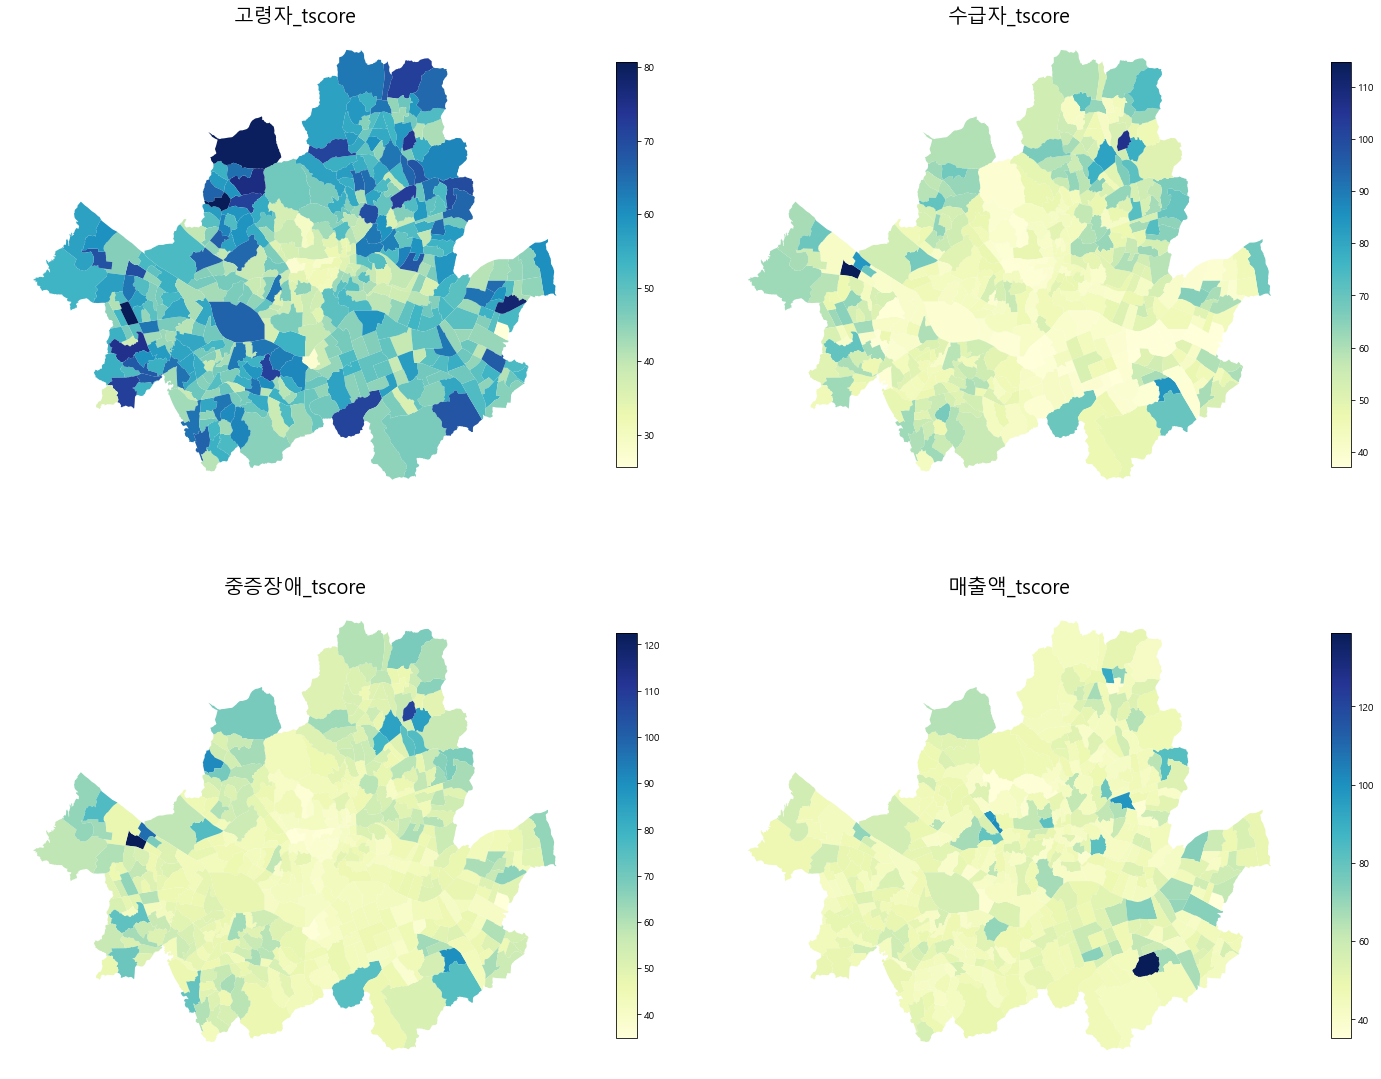

In [216]:
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
col_n = 2
row_n = 2
title = ['고령자_tscore', '수급자_tscore', '중증장애_tscore', '매출액_tscore']
fig, axes = plt.subplots(ncols=col_n, nrows=row_n, figsize=(20,row_n*8))

plt.xlim()      # X축의 범위: [xmin, xmax]
plt.ylim()     # Y축의 범위: [ymin, ymax]
plt.tight_layout()


for i, col in enumerate(지도시각화3.columns[1:]):
    ax = 지도시각화3.plot(지도시각화3[col], ax=axes[int(i/col_n),int(i%col_n)], legend=True, legend_kwds={"shrink":0.75, "fraction":0.1}, cmap="YlGnBu")
    ax.set_axis_off()
    ax.set_title(title[i], fontsize=20)

### 예시 코드

In [3]:
f = open("DataSet/심야약국_원본데이터반출/B049. 서울시 가족관계등록 신고현황 통계/2. 파일데이터/TN_PF_RRP_INCDNT_PROCESS_CURSTT.txt", 'r', encoding='utf-8')
text = f.read()
text = text.replace("`", "")
f.close()

temp = open("B049.txt", 'w')
print(text, file=temp)
temp.close()

In [4]:
data049 = pd.read_csv("B049.txt", sep="|", encoding="cp949")
data049

,ctprvn_nm,signgu_nm,emd_nm,regist_se,inqire_ym,managt_cnt,ldadng_dt
0,서울특별시,서울특별시 강남구,서울특별시 강남구청,개명,201501,187,2017-11-21 16:58:47
1,서울특별시,서울특별시 강남구,서울특별시 강남구청,사망,201501,183,2017-11-21 16:58:47
2,서울특별시,서울특별시 강남구,서울특별시 강남구청,이혼,201501,61,2017-11-21 16:58:47
3,서울특별시,서울특별시 강남구,서울특별시 강남구청,출생,201501,418,2017-11-21 16:58:47
4,서울특별시,서울특별시 강남구,서울특별시 강남구청,혼인,201501,522,2017-11-21 16:58:47
...,...,...,...,...,...,...,...
11402,서울특별시,재외국민 가족관계등록사무소,재외국민 가족관계등록사무소,개명,202204,2,2022-05-25 15:08:21
11403,서울특별시,재외국민 가족관계등록사무소,재외국민 가족관계등록사무소,사망,202204,297,2022-05-25 15:08:21
11404,서울특별시,재외국민 가족관계등록사무소,재외국민 가족관계등록사무소,이혼,202204,97,2022-05-25 15:08:21
11405,서울특별시,재외국민 가족관계등록사무소,재외국민 가족관계등록사무소,출생,202204,1320,2022-05-25 15:08:21


In [5]:
data049["signgu_nm"].unique()

array(['서울특별시 강남구', '서울특별시 강동구', '서울특별시 강북구', '서울특별시 강서구', '서울특별시 관악구',
       '서울특별시 광진구', '서울특별시 구로구', '서울특별시 금천구', '서울특별시 노원구', '서울특별시 도봉구',
       '서울특별시 동대문구', '서울특별시 동작구', '서울특별시 마포구', '서울특별시 서대문구', '서울특별시 서초구',
       '서울특별시 성동구', '서울특별시 성북구', '서울특별시 송파구', '서울특별시 양천구', '서울특별시 영등포구',
       '서울특별시 용산구', '서울특별시 은평구', '서울특별시 종로구', '서울특별시 중구', '서울특별시 중랑구',
       '재외국민 가족관계등록사무소'], dtype=object)

In [6]:
data049["emd_nm"].unique()

array(['서울특별시 강남구청', '서울특별시 강동구청', '서울특별시 강북구청', '서울특별시 강서구청',
       '서울특별시 관악구청', '서울특별시 광진구청', '서울특별시 구로구청', '서울특별시 금천구청',
       '서울특별시 노원구청', '서울특별시 도봉구청', '서울특별시 동대문구청', '서울특별시 동작구청',
       '서울특별시 마포구청', '서울특별시 서대문구청', '서울특별시 서초구청', '서울특별시 성동구청',
       '서울특별시 성북구청', '서울특별시 송파구청', '서울특별시 양천구청', '서울특별시 영등포구청',
       '서울특별시 용산구청', '서울특별시 은평구청', '서울특별시 종로구청', '서울특별시 중구청',
       '서울특별시 중랑구청', '재외국민 가족관계등록사무소'], dtype=object)

In [7]:
f = open("DataSet/심야약국_원본데이터반출/B055. 서울시 장애인 등급별 자치구 거주통계/2. 파일데이터/TN_PF_PPS_DSPSN_ATDRC_TY.txt", 'r', encoding='utf-8')
text = f.read()
text = text.replace("`", "")
f.close()

temp = open("B055.txt", 'w')
print(text, file=temp)
temp.close()

In [8]:
data049 = pd.read_csv("B055.txt", sep="|", encoding="cp949")
data049.head()

,stdr_ym,atdrc_nm,physicl_dspsn_co,visual_dspsn_co,arss_dspsn_co,lang_dspsn_co,intel_dspsn_co,brain_dspsn_co,autism_dspsn_co,mental_dspsn_co,kidney_dspsn_co,heart_dspsn_co,rsporg_dspsn_co,liver_dspsn_co,face_dspsn_co,ostm_urstm_dspsn_co,eplpsy_dspsn_co,ldadng_dt
0,2015,강남구,7251,1685,1474,125,996,1809,498,808,754,72,109,135,19,91,52,2018-08-09 11:24:54
1,2015,강동구,8781,1828,1577,165,1246,2029,336,574,712,67,85,115,16,109,62,2018-08-09 11:24:54
2,2015,강북구,8515,2009,1835,129,1073,1840,115,690,629,33,99,74,13,131,58,2018-08-09 11:24:54
3,2015,강서구,13463,2797,3033,203,1835,2980,267,1572,1119,96,184,124,39,155,129,2018-08-09 11:24:54
4,2015,관악구,10216,2368,1997,147,1208,2034,193,828,783,56,90,104,21,122,63,2018-08-09 11:24:54


In [9]:
new_col = [
"기준년월",
"자치구명",
"지체장애인수",
"시각장애인수",
"청각장애인수",
"언어장애인수",
"지적장애인수",
"뇌병변장애인수",
"자폐성장애인수",
"정신장애인수",
"신장장애인수",
"심장장애인수",
"호흡기장애인수",
"간장애인수",
"안면장애인수",
"장루요루장애인수",
"뇌전증장애인수",
"적재일시"
]

In [10]:
data049.columns = new_col

In [11]:
data049 = data049.drop(["적재일시"], axis=1)
data049

,기준년월,자치구명,지체장애인수,시각장애인수,청각장애인수,언어장애인수,지적장애인수,뇌병변장애인수,자폐성장애인수,정신장애인수,신장장애인수,심장장애인수,호흡기장애인수,간장애인수,안면장애인수,장루요루장애인수,뇌전증장애인수
0,2015,강남구,7251,1685,1474,125,996,1809,498,808,754,72,109,135,19,91,52
1,2015,강동구,8781,1828,1577,165,1246,2029,336,574,712,67,85,115,16,109,62
2,2015,강북구,8515,2009,1835,129,1073,1840,115,690,629,33,99,74,13,131,58
3,2015,강서구,13463,2797,3033,203,1835,2980,267,1572,1119,96,184,124,39,155,129
4,2015,관악구,10216,2368,1997,147,1208,2034,193,828,783,56,90,104,21,122,63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,2017,용산구,3806,987,950,69,506,860,90,297,320,19,47,63,8,74,20
71,2017,은평구,9488,2302,2620,178,1686,2296,276,1128,768,49,138,127,26,163,56
72,2017,종로구,2853,736,713,47,372,610,105,263,230,18,23,40,6,28,20
73,2017,중구,2732,734,644,32,322,583,51,234,218,14,25,31,6,43,25


In [12]:
new_col = new_col[:-1]

In [13]:
data049_1 = data049.groupby(["자치구명", "기준년월"]).sum()
data049_2 = data049.groupby("자치구명").sum()
data049_2 = data049_2.drop("기준년월", axis=1)
data049_2

,지체장애인수,시각장애인수,청각장애인수,언어장애인수,지적장애인수,뇌병변장애인수,자폐성장애인수,정신장애인수,신장장애인수,심장장애인수,호흡기장애인수,간장애인수,안면장애인수,장루요루장애인수,뇌전증장애인수
자치구명,,,,,,,,,,,,,,,
강남구,21051,4987,4633,372,3030,5384,1572,2524,2284,192,333,413,59,272,147
강동구,25452,5447,5069,485,3800,6011,1029,1703,2150,186,270,352,49,341,190
강북구,25165,6039,5863,408,3336,5485,375,2123,1956,110,301,229,37,376,155
강서구,39984,8470,9746,659,5685,9045,881,4806,3542,257,522,384,110,484,378
관악구,29831,6998,6308,466,3730,6122,612,2540,2497,154,297,303,60,377,180
광진구,18385,3987,3974,272,2324,3907,417,1550,1581,123,174,197,27,299,147
구로구,26141,5610,5588,422,3337,5123,691,1690,1850,212,314,262,72,354,142
금천구,16625,3532,3695,263,2049,3207,266,1209,1210,165,167,107,45,220,113
노원구,39002,8344,8655,663,6170,9079,924,4368,2993,344,479,288,104,540,335


In [14]:
data3 = data049_2.sum(axis=1).to_frame("장애인 통계")
data3

,장애인 통계
자치구명,
강남구,47253
강동구,52534
강북구,51958
강서구,84953
관악구,60475
광진구,37364
구로구,51808
금천구,32873
노원구,82288


In [15]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
fitted = scaler.fit(data3)
data3_scale = scaler.transform(data3)

In [16]:
data4_scale = pd.DataFrame(data3_scale, columns=["장애인가중치"], index=data3.index)
data4_scale = data4_scale.reset_index()
data4_scale

,자치구명,장애인가중치
0,강남구,0.000000
1,강동구,0.329548
2,강북구,0.293604
3,강서구,2.352574
4,관악구,0.825086
5,광진구,-0.617098
6,구로구,0.284243
7,금천구,-0.897348
8,노원구,2.186271
9,도봉구,-0.136287


### 시각화

In [17]:
import seaborn as sns
import matplotlib.font_manager as fm
font_list = [font.name for font in fm.fontManager.ttflist]
font_list

['STIXSizeFiveSym',
 'STIXSizeFourSym',
 'STIXGeneral',
 'cmmi10',
 'DejaVu Serif Display',
 'STIXGeneral',
 'STIXNonUnicode',
 'STIXSizeTwoSym',
 'DejaVu Sans Mono',
 'STIXNonUnicode',
 'DejaVu Sans',
 'DejaVu Serif',
 'cmtt10',
 'STIXSizeOneSym',
 'cmss10',
 'DejaVu Sans Mono',
 'DejaVu Serif',
 'STIXNonUnicode',
 'DejaVu Sans',
 'DejaVu Serif',
 'STIXSizeThreeSym',
 'STIXSizeThreeSym',
 'STIXSizeOneSym',
 'STIXGeneral',
 'STIXNonUnicode',
 'STIXSizeTwoSym',
 'DejaVu Sans',
 'DejaVu Sans Mono',
 'cmex10',
 'STIXGeneral',
 'DejaVu Sans Display',
 'DejaVu Serif',
 'cmb10',
 'STIXSizeFourSym',
 'DejaVu Sans',
 'DejaVu Sans Mono',
 'cmr10',
 'cmsy10',
 'Trebuchet MS',
 'Microsoft Tai Le',
 'Segoe UI Emoji',
 'Eras Medium ITC',
 'Arial',
 'Bodoni MT',
 'Calisto MT',
 'Lucida Bright',
 'Cooper Black',
 'Felix Titling',
 'Lucida Bright',
 'Segoe UI',
 'NanumBarunpen',
 'Calibri',
 'High Tower Text',
 'Nanum Pen Script',
 'Garamond',
 'Copperplate Gothic Light',
 'Eras Bold ITC',
 'Rockwell'

<AxesSubplot:xlabel='자치구명', ylabel='장애인가중치'>

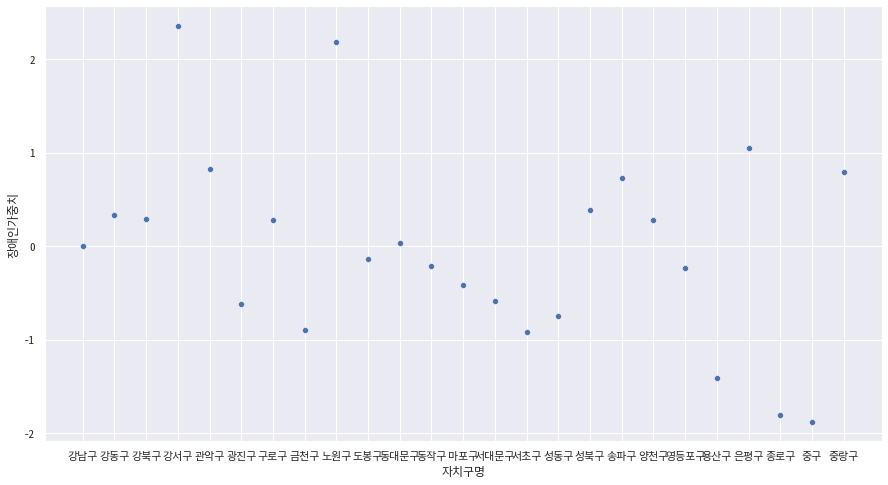

In [18]:
plt.rcParams['font.family'] = 'Noto Sans Mono CJK KR'
sns.set(rc = {'figure.figsize':(15,8)}, font="Noto Sans Mono CJK KR")
sns.scatterplot(x=data4_scale["자치구명"], y="장애인가중치", data=data4_scale)

<AxesSubplot:ylabel='장애인가중치'>

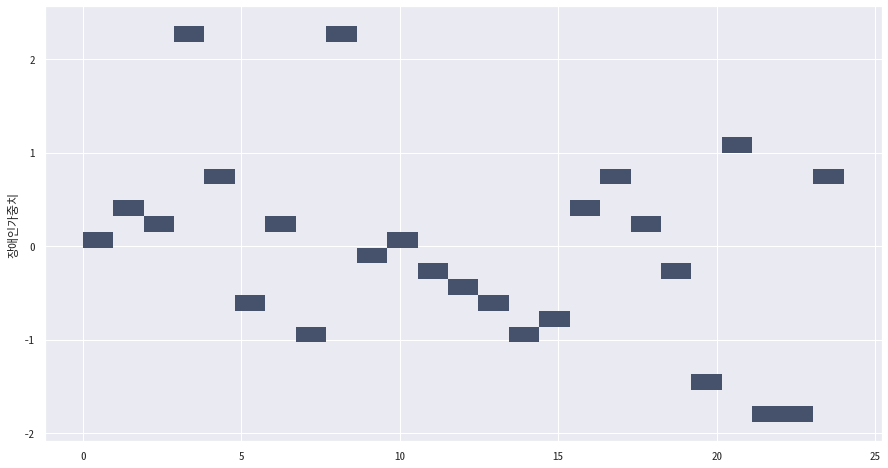

In [19]:
sns.histplot(x=data4_scale.index, y=data4_scale["장애인가중치"], bins=25, data=data4_scale)

c:\Users\chldl\Desktop\공부\공모전\통계데이터활용경진대회\Codespace\statics\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\chldl\Desktop\공부\공모전\통계데이터활용경진대회\Codespace\statics\lib\site-packages\seaborn\distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


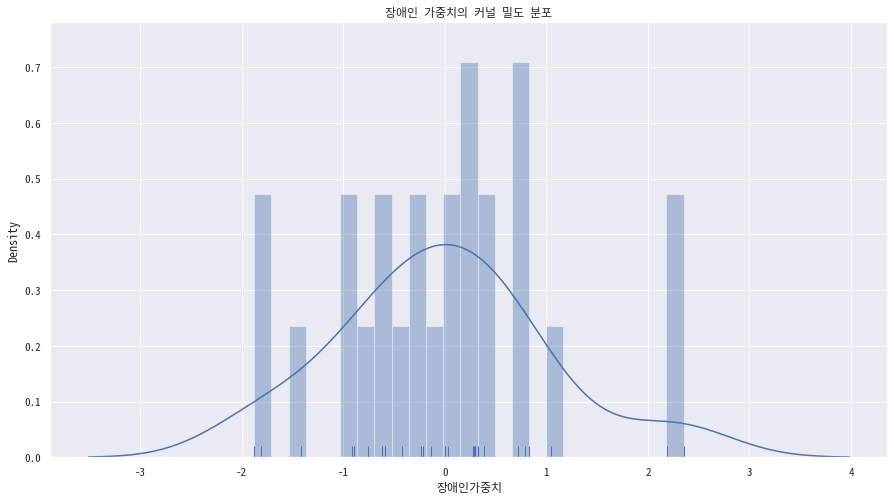

In [20]:
sns.distplot(data4_scale["장애인가중치"], bins=25, kde=True, rug=True)
plt.title("장애인 가중치의 커널 밀도 분포")
plt.show()

In [25]:
seoul3 = pd.merge(seoul2, data4_scale, how='left', left_on='SIG_KOR_NM', right_on="자치구명")
seoul3 = seoul3.drop("자치구명", axis=1)

In [26]:
seoul3

,SIG_CD,SIG_KOR_NM,EMD_CD,EMD_KOR_NM,geometry_y,장애인가중치
0,11110,종로구,11110101,청운동,"POLYGON ((126.97556 37.58968, 126.97549 37.589...",-1.805367
1,11110,종로구,11110102,신교동,"POLYGON ((126.97031 37.58418, 126.97033 37.584...",-1.805367
2,11110,종로구,11110103,궁정동,"POLYGON ((126.97400 37.58654, 126.97401 37.586...",-1.805367
3,11110,종로구,11110104,효자동,"POLYGON ((126.97356 37.58323, 126.97355 37.582...",-1.805367
4,11110,종로구,11110105,창성동,"POLYGON ((126.97353 37.58182, 126.97354 37.581...",-1.805367
...,...,...,...,...,...,...
462,11740,강동구,11740106,둔촌동,"POLYGON ((127.15669 37.53756, 127.15654 37.537...",0.329548
463,11740,강동구,11740107,암사동,"POLYGON ((127.14353 37.55490, 127.14343 37.554...",0.329548
464,11740,강동구,11740108,성내동,"POLYGON ((127.13424 37.53556, 127.13423 37.535...",0.329548
465,11740,강동구,11740109,천호동,"POLYGON ((127.14153 37.55080, 127.14154 37.550...",0.329548
